# Results of scalability test
This notebook relies on a result file produced by [scalability](./scalability.ipynb) (or a script version of it)

In [93]:
#from collections import ChainMap
from collections import defaultdict
from functools import reduce
from itertools import cycle, chain, count
import numpy as np
import pandas as pd
import statsmodels.api as sm


from matplotlib.ticker import FuncFormatter
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

sns.set_style()
%matplotlib inline

## Helpers

In [94]:
def rowdicts2DataFrame(rowdicts):
    rowdicts = list(rowdicts)
    return pd.DataFrame({k: [row.get(k, np.nan) for row in rowdicts] for k in {k for r in rowdicts for k in r}}).sort_index(axis='columns')

## Data

In [95]:
result_file = 'timings.pickle'
timings = pd.read_pickle(result_file)

## Calculated Fields

In [124]:
timings['log_possible_blocks'] = np.log10(timings['granularity']) * timings['columns']
timings['log_possible_blocks_per_row'] = timings['log_possible_blocks'] - np.log10(timings['rows'])
timings['production_rate'] = timings['index_length'] / timings['elapsed_seconds']
timings['log_production_rate'] = np.log10(timings['production_rate'])
timings['label'] = timings['label'].str.replace('Adjacent', 'Neighbourhood')
timings['category'] = timings['label'].str.replace(r'\s+-.*', '')

timings.head()

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


,columns,elapsed_seconds,granularity,index_length,instances_per_entity,label,length_full,memory_overflow,rows,max_nulls,ndx_sorting_keys,combinations_processed,max_rank_differences,reduction_ratio,log_possible_blocks,log_possible_blocks_per_row,production_rate,log_production_rate,category
0,1.0,7.293391,1000.0,499500.0,1.0,Full,499500.0,0.0,1000.0,NaN,NaN,NaN,NaN,0.000000,3.0,0.0,68486.661417,4.835606,Full
1,1.0,0.150020,1000.0,473.0,1.0,Standard Blocking,499500.0,0.0,1000.0,NaN,NaN,NaN,NaN,0.999053,3.0,0.0,3152.912945,3.498712,Standard Blocking
2,1.0,0.181060,1000.0,0.0,1.0,Sorted Neighbourhood,499500.0,0.0,1000.0,NaN,NaN,NaN,NaN,1.000000,3.0,0.0,0.000000,-inf,Sorted Neighbourhood
3,1.0,0.702335,1000.0,473.0,1.0,Neighbourhood Blocking - Standard Blocking set...,499500.0,0.0,1000.0,0.0,None,NaN,NaN,0.999053,3.0,0.0,673.467790,2.828317,Neighbourhood Blocking
4,1.0,0.717090,1000.0,2025.0,1.0,Neighbourhood Blocking - no wildcards,499500.0,0.0,1000.0,0.0,NaN,NaN,NaN,0.995946,3.0,0.0,2823.913316,3.450851,Neighbourhood Blocking


## Timing plots

Label: Full, Filtering: 
R-squared: 0.9867077861141783; params: [  1.18665065e+00   1.08455949e-06]


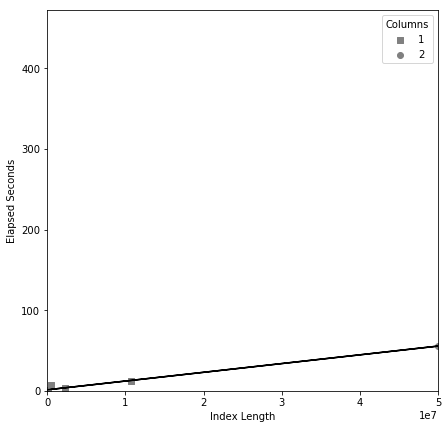

Label: Neighbourhood Blocking - 1 wildcard, Filtering: 
R-squared: 0.09016353989650072; params: [  9.22648955e+00   3.02113556e-06]


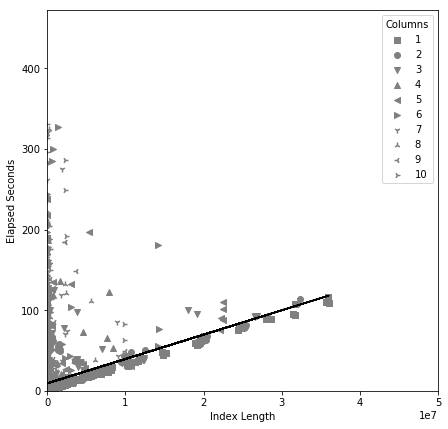

Label: Neighbourhood Blocking - 2 wildcards, Filtering: 
R-squared: 0.07085610245124174; params: [  1.02712227e+01   3.14759623e-06]


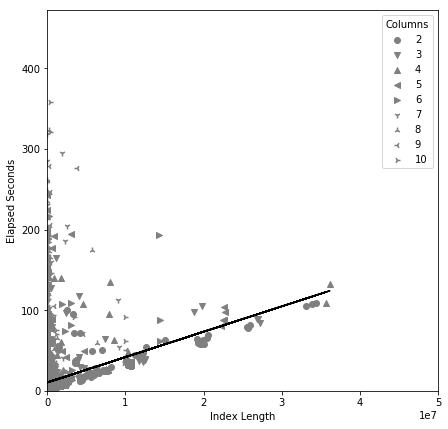

Label: Neighbourhood Blocking - Standard Blocking settings, Filtering: 
R-squared: 0.3319524156871877; params: [  4.92420222e+00   3.18478709e-06]


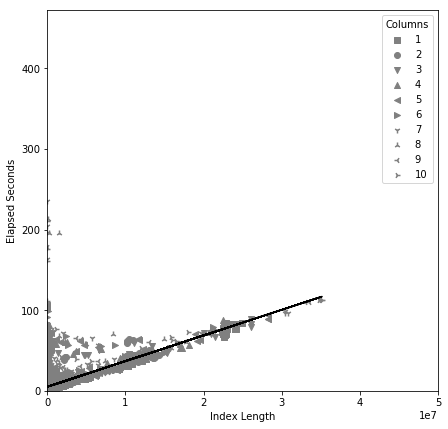

Label: Neighbourhood Blocking - no wildcards, Filtering: 
R-squared: 0.07984313399835108; params: [  8.68292316e+00   3.11627765e-06]


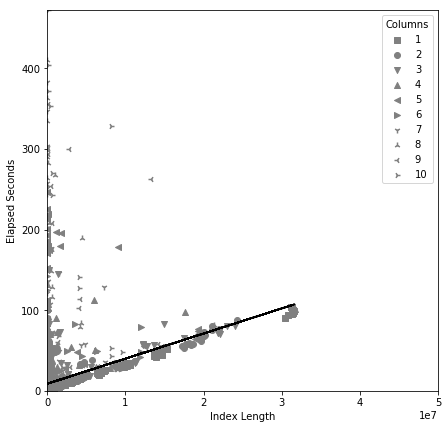

Label: Sorted Neighbourhood, Filtering: 
R-squared: 0.9615448241790935; params: [  1.22480932e+00   1.03391369e-05]


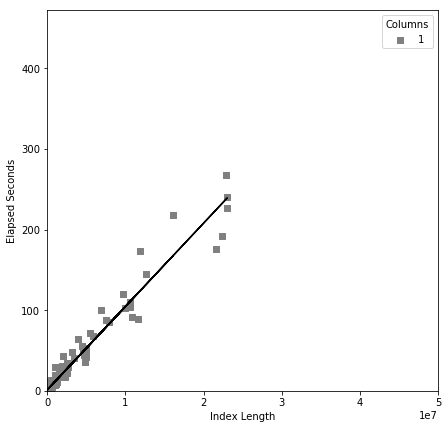

Label: Standard Blocking, Filtering: 
R-squared: 0.821865886270116; params: [  1.55325309e+00   3.23378229e-06]


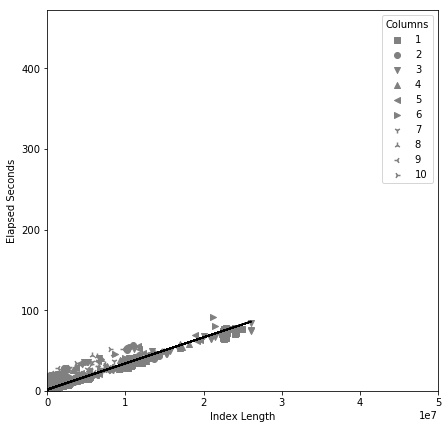

Label: Neighbourhood Blocking, Filtering: Non-sparse
R-squared: 0.9947316713070901; params: [  2.62046799e-01   3.19714533e-06]


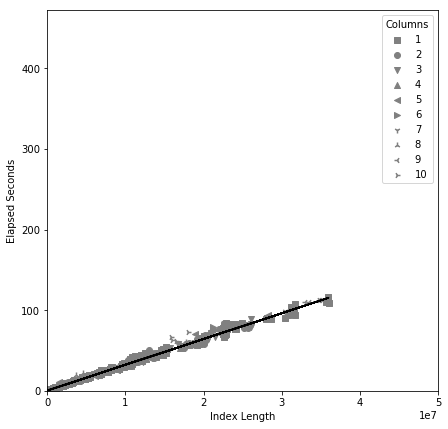

Label: Standard Blocking, Filtering: Non-sparse
R-squared: 0.9912601651482736; params: [  2.33410491e-01   3.12946588e-06]


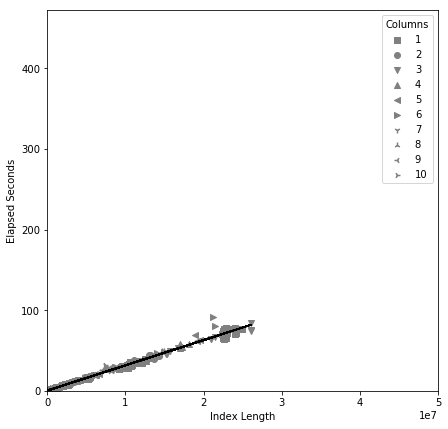

,Method,Filtering,Intercept,Slope,R-squared
0,Full,,1.19,1.08,0.99
1,Neighbourhood Blocking - 1 wildcard,,9.23,3.02,0.09
2,Neighbourhood Blocking - 2 wildcards,,10.27,3.15,0.07
3,Neighbourhood Blocking - Standard Blocking set...,,4.92,3.18,0.33
4,Neighbourhood Blocking - no wildcards,,8.68,3.12,0.08
5,Sorted Neighbourhood,,1.22,10.34,0.96
6,Standard Blocking,,1.55,3.23,0.82
7,Neighbourhood Blocking,Non-sparse,0.26,3.20,0.99
8,Standard Blocking,Non-sparse,0.23,3.13,0.99


In [125]:
x_col, y_col, label_col, *graph_cols = ['index_length', 'elapsed_seconds', 'columns', 'label']


label_description = int

max_cols = 2
#filtered_timings = timings[timings['elapsed_seconds'] < 100]
filtered_timings = timings[~timings['elapsed_seconds'].isnull()]

sparsity_multiple = 100

def column_description(column_name):
    return column_name.replace('_', ' ').title()

def marker_cycle(first='', omissions=''):
    first = list(first); omissions=list(omissions)
    markers = first + [k for k, v in MarkerStyle.markers.items() if (v != 'nothing') and (k not in first) and (k not in omissions)]
    return cycle(markers)
    

label_markers = defaultdict(iter(marker_cycle(omissions='.')).__next__)

fit_lines_rowdicts = []
border = 0.1
xlim = (filtered_timings[x_col].min()-border, filtered_timings[x_col].max()+border)
ylim = (filtered_timings[y_col].min()-border, filtered_timings[y_col].max()+border)
for grouping_name, grouping in [('', filtered_timings.groupby(graph_cols)), 
                                ('Non-sparse', filtered_timings[(filtered_timings['log_possible_blocks_per_row'] < -np.log10(sparsity_multiple)) & (~filtered_timings['label'].isin(['Full', 'Sorted Neighbourhood']))].groupby(graph_cols[:-1]+['category'])),
                               ]:
    for graph_keys, graph_vals in grouping:
        if len(graph_cols) == 1:
            graph_keys = [graph_keys]
        description = ', '.join('{0}: {1}'.format(column_description(col), key) for col, key in chain(zip(graph_cols, graph_keys), [('filtering', grouping_name)]))
        print(description)
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        ax.set_xlabel(column_description(x_col)); ax.set_ylabel(column_description(y_col))
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        for label, to_plot in sorted(graph_vals.groupby(label_col)):
            ax.scatter(to_plot[x_col].values, to_plot[y_col].values, marker=label_markers[label], color='grey', label=label_description(label))
        x, y = [graph_vals[col].values for col in [x_col, y_col]]
        fit = sm.OLS(y, sm.add_constant(x)).fit()
        print('R-squared: {fit.rsquared}; params: {fit.params}'.format(**locals()))
        ax.plot(x, fit.params[0] + fit.params[1] * x, color='black')#, label='fit')
        rowdict = {'grouping_name':grouping_name, 'R-squared':fit.rsquared}
        rowdict.update({'key{}'.format(suffix): val for suffix, val in zip(chain([''], ('_{}'.format(c) for c in count())), graph_keys)})
        rowdict.update(dict(zip(['Intercept', 'Slope'], fit.params)))
        fit_lines_rowdicts.append(rowdict)
        plt.legend(loc='upper right', title=column_description(label_col))
        plt.show()

fit_lines = rowdicts2DataFrame(fit_lines_rowdicts).rename(columns={'grouping_name': 'Filtering', 'key':'Method'})[['Method', 'Filtering', 'Intercept', 'Slope', 'R-squared']]
fit_lines['Slope'] = fit_lines['Slope'] * 1e6
display(fit_lines.round(2))
    

In [126]:
print(fit_lines.round(2).to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
                                            Method &   Filtering &  Intercept &  Slope &  R-squared \\
\midrule
                                              Full &             &       1.19 &   1.08 &       0.99 \\
               Neighbourhood Blocking - 1 wildcard &             &       9.23 &   3.02 &       0.09 \\
              Neighbourhood Blocking - 2 wildcards &             &      10.27 &   3.15 &       0.07 \\
 Neighbourhood Blocking - Standard Blocking set... &             &       4.92 &   3.18 &       0.33 \\
             Neighbourhood Blocking - no wildcards &             &       8.68 &   3.12 &       0.08 \\
                              Sorted Neighbourhood &             &       1.22 &  10.34 &       0.96 \\
                                 Standard Blocking &             &       1.55 &   3.23 &       0.82 \\
                            Neighbourhood Blocking &  Non-sparse &       0.26 &   3.20 &       0.99 \\
                                

## Production rate plots

All


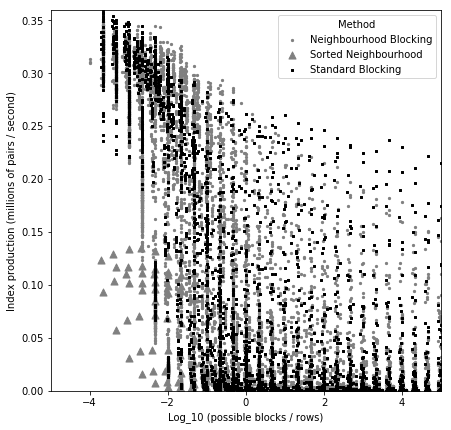

Longer than 1 second


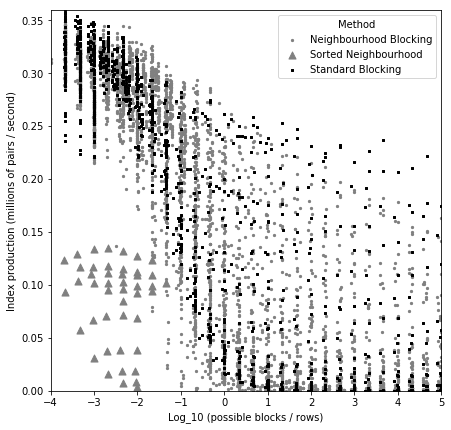

In [138]:
cols_labels_and_scales = [('log_possible_blocks_per_row', 'Log_10 (possible blocks / rows)', 1),
                          ('production_rate', 'Index production (millions of pairs / second)', 1e-6),
                         ]

pre_filtered_timings = timings[(timings['label'] != 'Full')
                               & (timings['log_possible_blocks_per_row'] <= 5)
                              ]


for description, filtered_timings in [('All', pre_filtered_timings),
                                      ('Longer than 1 second', pre_filtered_timings[pre_filtered_timings['elapsed_seconds']>1]),
                                     ]:
    print(description)
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    for mth, (_, label, __) in zip([ax.set_xlabel, ax.set_ylabel], cols_labels_and_scales):
        mth(label)
    for mth, limits in zip([ax.set_xlim, ax.set_ylim], [(filtered_timings[col].min()*scale, filtered_timings[col].max()*scale) for col, _, scale in cols_labels_and_scales]):
        mth(limits)
    for (cat, vals), marker, color, s in zip(filtered_timings.groupby('category'), marker_cycle(first='o^s'), cycle(['grey', 'grey', 'black']), cycle([5, 50, 5])):
        ax.scatter(*[vals[col].values * scale for col, _, scale in cols_labels_and_scales], 
                   marker=marker, color=color, label=cat, s=s)
    plt.legend(title='Method', loc='upper right')
    plt.show()

